In [ ]:
try:
    import netket as nk
except ImportError:
    !pip install --quiet --upgrade pip
    !pip install --quiet --upgrade netket
    import netket as nk

import os

!pip install --quiet --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_releases.html
os.environ["JAX_PLATFORM_NAME"] = "gpu"
import jax
from netket.operator.spin import sigmax,sigmaz, sigmay
from scipy.sparse.linalg import eigsh
from netket.utils.types import NNInitFunc
from typing import Any, Dict
import json
import numpy as np

# numerical operations in the model should always use jax.numpy 
# instead of numpy because jax supports computing derivatives. 
# If you want to better understand the difference between the two, check
# https://flax.readthedocs.io/en/latest/notebooks/jax_for_the_impatient.html
import jax.numpy as jnp

# Flax is a framework to define models using jax
import flax
# we refer to `flax.linen` as `nn`. It's a repository of 
# layers, initializers and nonlinear functions.
import flax.linen as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import networkx as nx

print(f"NetKet version: {nk.__version__}")
jnp.set_printoptions(precision=5)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.9/485.9 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 103.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.2/720.2 kB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
NetKet version: 3.8


In [ ]:
stddev_ker=0.1
default_kernel_init = nn.initializers.normal(stddev_ker) 
default_bias_init = nn.initializers.normal(stddev_ker)

from dataclasses import dataclass


class RBMConv(nn.Module):
    r"""A restricted boltzman Machine, equivalent to a 2-layer FFNN with a
    nonlinear activation function in between.
    """
    graph: nk.graph.Graph
    
    param_dtype: Any = np.float64
    """The dtype of the weights."""
    activation: Any = nk.nn.log_cosh
    """The nonlinear activation function."""

    enable_norm: bool = True
    enable_zeros: bool = False
    enable_vis_conv: bool = False

    alpha: int = 1
    """feature density. Number of features equal to alpha * input.shape[-1]"""
    use_hidden_bias: bool = True
    """if True uses a bias in the dense layer (hidden layer bias)."""
    use_visible_bias: bool = True
    """if True adds a bias to the input not passed through the nonlinear layer."""
    precision: Any = None
    """numerical precision of the computation see :class:`jax.lax.Precision` for details."""

    kernel_init: NNInitFunc = default_kernel_init
    """Initializer for the Dense layer matrix."""
    hidden_bias_init: NNInitFunc = default_kernel_init
    """Initializer for the hidden bias."""
    visible_bias_init: NNInitFunc = default_kernel_init
    """Initializer for the visible bias."""


    def EnableConv(self):
        adj_matrix = np.eye(self.graph.n_nodes)
        if self.enable_zeros:
            adj_matrix = np.zeros((self.graph.n_nodes, self.graph.n_nodes))

        for u,v in self.graph.edges():
            adj_matrix[u][v] = adj_matrix[v][u] = 1

        if self.enable_norm:
            adj_matrix /= (adj_matrix.sum(axis=0) + self.enable_zeros)
        self.adj_matrix = adj_matrix

    def setup(self):
        self.dense = nn.Dense(
            name="Dense",
            features=int(self.alpha * self.graph.n_nodes),
            param_dtype=self.param_dtype,
            precision=self.precision,
            use_bias=self.use_hidden_bias,
            kernel_init=self.kernel_init,
            bias_init=self.hidden_bias_init,
        )
        self.v_bias = self.param(
                "visible_bias",
                self.visible_bias_init,
                (g.n_nodes,),
                self.param_dtype,
            )
        self.adj_matrix = np.eye(g.n_nodes)
        adj_matrix = np.eye(self.graph.n_nodes)
        if self.enable_zeros:
            adj_matrix = np.zeros((self.graph.n_nodes, self.graph.n_nodes))

        for u,v in self.graph.edges():
            adj_matrix[u][v] = adj_matrix[v][u] = 1

        if self.enable_norm:
            adj_matrix /= (adj_matrix.sum(axis=0) + self.enable_zeros)
        self.adj_matrix = adj_matrix
        
    @nn.compact
    def __call__(self, input):
        
        # print(input.shape)
        x_conv = jnp.dot(input, self.adj_matrix)
        x = self.dense(x_conv)
        x = self.activation(x)
        x = jnp.sum(x, axis=-1)

        if self.use_visible_bias:
           
            if self.enable_vis_conv:
                out_bias = jnp.dot(x_conv, self.v_bias)
            else:
                out_bias = jnp.dot(input, self.v_bias)
            return x + out_bias
        else:
            return x

In [ ]:
# # Define a 1d chain
# N = 20
# g = nk.graph.Hypercube(length=N, n_dim=1, pbc=True) # in tutorial

# # Define the Hilbert space based on this graph
# # We impose to have a fixed total magnetization of zero 
# hi = nk.hilbert.Spin(s=0.5, N=g.n_nodes) # , total_sz=0)

# Gamma = -1
# H = sum([Gamma*sigmax(hi,i) for i in range(N)])
# V=-1
# H += sum([V*sigmaz(hi,i)*sigmaz(hi,(i+1)%N) for i in range(N)])

In [ ]:
N = 8

g_nx = nx.circulant_graph(N, [1])
edges = [(u,v) for u, v in g_nx.edges]

In [ ]:
g = nk.graph.Graph(edges=edges)
hi = nk.hilbert.Spin(s=1/2, N=g.n_nodes)

Gamma = -1
H = sum([Gamma*sigmax(hi,i) for i in range(g.n_nodes)])
V=-1
H += sum([V*sigmaz(hi,u)*sigmaz(hi,v) for u,v in edges])

# Gamma = -1
# H = sum([Gamma*sigmax(hi,i) for i in range(N)])
# V=-1
# H += sum([V*sigmaz(hi,i)*sigmaz(hi,(i+1)%N) for i in range(N)])

In [ ]:
sp_h=H.to_sparse()
sp_h.shape

(256, 256)

In [ ]:
from scipy.sparse.linalg import eigsh

eig_vals, eig_vecs = eigsh(sp_h, k=1, which="SA")

print("eigenvalues with scipy sparse:", eig_vals)

E_gs = eig_vals[0]

eigenvalues with scipy sparse: [-10.25166]


In [ ]:
print([item for item in g.edges()])

In [ ]:
def get_adj_matrix(g): 
    adj_matrix = np.eye(g.n_nodes) 
    for u,v in g.edges():
        adj_matrix[u][v] = adj_matrix[v][u] = 1

    # print(adj_matrix)
    adj_matrix /= adj_matrix.sum(axis=0)
    # print(adj_matrix)
    return adj_matrix

In [ ]:
type(get_adj_matrix(g))

numpy.ndarray

In [ ]:
plot_data = {}

In [ ]:
for ma, model_name in ((RBMConv(graph=g, alpha=2), 'RBM_conv'),  
                       (nk.models.RBM(alpha=2), 'RBM_default'), ):
    # Build the sampler
    # sa = nk.sampler.MetropolisExchange(hilbert=hi,graph=g)
    plot_data[model_name] = 0
    sa = nk.sampler.MetropolisLocal(hi,  n_chains_per_rank = 50)

    # Optimizer
    op = nk.optimizer.Sgd(learning_rate=0.01)

    # Stochastic Reconfiguration
    sr = nk.optimizer.SR(diag_shift=0.01)

    # The variational state
    vs = nk.vqs.MCState(sa, ma, n_samples=1050)

    gs = nk.VMC(
        hamiltonian=H,
        optimizer=op,
        preconditioner=sr,
        variational_state=vs)

    log=nk.logging.RuntimeLog()
    start = time.time()
    N_iters=100
    gs.run(out=log, n_iter=N_iters)
    end = time.time()
    plot_data[model_name] = log.data


    res_energy=vs.expect(H)
    print(f"Target energy: {E_gs}")
    print(f"Optimized energy: {res_energy}")

    error=abs((res_energy.mean-E_gs)/E_gs)
    print(f"relative error   : {error * 100:.2f}%")
    plot_data[model_name] = log.data

    print('### RBM calculation')
    print('Has',vs.n_parameters,'parameters')
    print('The RBM calculation took',end-start,'seconds')

In [ ]:
skip_iter = 30
plt.hlines([E_gs], xmin=skip_iter, xmax=N_iters, color='black', label="Exact")

# for model_name in ('RBM_conv', 'RBM_default'):
for model_name in ('RBM_conv', 'RBM_default'):
    cur_name = model_name # 'FFN' #
    plt.errorbar(plot_data[cur_name]["Energy"].iters[skip_iter:], plot_data[cur_name]["Energy"].Mean[skip_iter:], 
                yerr=plot_data[cur_name]["Energy"].Sigma[skip_iter:], label=cur_name)
  
    plt.legend()

    plt.xlabel('Iterations')
    plt.ylabel('Energy')

# MaxCut

In [ ]:
os.environ["JAX_PLATFORM_NAME"] = "gpu"

In [ ]:
want_exact = True # 536, 929, 1430 
edgelist = []
skip_first_line = True

if want_exact:
    with  open('g10_05.0') as f:
        if skip_first_line:
            next(f)
        for line in f:
            start, end = line.split(' ')[0:2]
            edgelist.append((int(start) - 1, int(end) - 1))
    mc_g = nx.from_edgelist(edgelist)
else:
    mc_g = nx.random_partition_graph(sizes=[20,80], p_in=0.3, p_out=0.3)


import pylab
f60 = pylab.figure(figsize=(15, 15))
nx.drawing.draw(mc_g, nx.drawing.kamada_kawai_layout(mc_g))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def get_max_cut_enegry(g, sol):
    return -2 * sol + g.size()

In [ ]:
# sol = nx.algorithms.approximation.randomized_partitioning(mc_g)
sol = nx.algorithms.approximation.one_exchange(mc_g)

color_map = []
for node in mc_g:
 if node in sol[1][0]:
    color_map.append('blue')
 else:
    color_map.append('green')

In [ ]:
exact_sol = 3050
# print('Approx cut_size = ', sol[0], ', exact = ', exact_sol)
# E_gs_approx = get_max_cut_enegry(mc_g, sol[0])
# print('Approx energy = ', E_gs_approx)
E_gs_exact = get_max_cut_enegry(mc_g, exact_sol)
print('Exact energy = ', E_gs_exact)

Exact energy =  -1439


In [ ]:
# print(sol)

In [ ]:
edges = [(u,v) for u, v in mc_g.edges]
print(edges)
# print(edges)
g = nk.graph.Graph(edges=edges)
print(("Created graph with {} vertices and {} edges".format(g.n_nodes, g.n_edges)))

[(0, 6), (0, 12), (0, 44), (0, 64), (0, 77), (0, 132), (0, 146), (0, 178), (0, 183), (0, 193), (0, 218), (0, 233), (0, 288), (0, 294), (0, 343), (0, 344), (0, 352), (0, 373), (0, 399), (0, 439), (0, 462), (0, 486), (0, 487), (0, 553), (0, 575), (0, 641), (0, 672), (0, 687), (0, 722), (0, 734), (0, 769), (0, 1), (0, 2), (0, 3), (0, 4), (0, 14), (0, 18), (0, 21), (0, 24), (0, 25), (0, 31), (0, 32), (0, 33), (0, 46), (0, 48), (0, 50), (0, 52), (0, 56), (0, 71), (0, 72), (0, 90), (0, 96), (0, 104), (0, 105), (0, 114), (0, 118), (0, 165), (0, 167), (0, 798), (0, 187), (0, 204), (0, 236), (0, 313), (0, 317), (0, 321), (0, 333), (0, 369), (0, 412), (0, 476), (0, 507), (0, 517), (0, 542), (0, 547), (0, 557), (0, 707), (0, 714), (0, 741), (0, 782), (6, 1), (6, 3), (6, 4), (6, 5), (6, 19), (6, 24), (6, 43), (6, 49), (6, 63), (6, 120), (6, 132), (6, 147), (6, 153), (6, 218), (6, 229), (6, 354), (6, 429), (6, 503), (6, 669), (6, 764), (6, 7), (6, 10), (6, 11), (6, 12), (6, 17), (6, 20), (6, 29), (

In [ ]:
# hi = nk.hilbert.Spin(1/2, g.n_nodes)

hi = nk.hilbert.CustomHilbert(local_states=[-1, 1], N=g.n_nodes)
sz_sz = [[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]
H = nk.operator.GraphOperator(hi, g, bond_ops=[sz_sz])

# H =  nk.operator.Ising(hilbert=hi, graph=g, h=0)

In [ ]:
plot_data = {}

In [ ]:
if input("Do u want to reset result? ") == "yes":
    conv_res = []
    rbm_res = []
else:
    assert False

# enable_norm : bool = False
# enable_zeros : bool = False

for i in range(1):
    print(i)
    for ma, model_name in ((RBMConv(graph=g, alpha=2, enable_norm = True, enable_zeros=True, enable_vis_conv=True, use_visible_bias=True, ), "RBM_zeros_enVB_VisConv"),
                        (nk.models.RBM(alpha=2), 'RBM_default'), 
                        ):
        
        hi = nk.hilbert.CustomHilbert(local_states=[-1, 1], N=g.n_nodes)
        sz_sz = [[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]
        H = nk.operator.GraphOperator(hi, g, bond_ops=[sz_sz]) / 2

        # Build the sampler
        print('\n', model_name)
        plot_data['0'] = 0

        # sa = nk.sampler.MetropolisExchange(hilbert=hi,graph=g)
        sa = nk.sampler.MetropolisLocal(hi) #, n_chains_per_rank = 50)

        # Optimize
        op = nk.optimizer.Sgd(learning_rate=0.01 if model_name != 'RBM_default' else 0.05)

        # Stochastic Reconfiguration
        sr = nk.optimizer.SR(diag_shift=0.01 if model_name != 'RBM_default' else 0.1) # try 0.01/0.5 sr

        # The variational state
        vs = nk.vqs.MCState(sa, ma, n_samples=1050)

        gs = nk.VMC(
            hamiltonian=H, 
            optimizer=op,
            preconditioner=sr,
            variational_state=vs)

        log=nk.logging.RuntimeLog()
        start = time.time()
        N_iters = 200
        # try ChainReset callback too 
        gs.run(out=log, n_iter=N_iters, callback=[]) # RHatStop(base=1.3, stop_cnt=30)])
                                                # , EnableConv() if model_name == 'RBM_conv' else AlwaysTrue()])
        end = time.time()
        plot_data[model_name] = log.data

        res_energy=vs.expect(H)
        E_gs = get_max_cut_enegry(mc_g, exact_sol)
        print(f"Target energy: {E_gs}")
        print(f"Optimized energy: {res_energy}")

        error=abs((res_energy.mean-E_gs)/E_gs)
        print(f"relative error   : {error * 100:.2f}%")
        plot_data[model_name] = log.data
        #log.data

        print('### RBM calculation')
        print('Has',vs.n_parameters,'parameters')
        print('The RBM calculation took',end-start,'seconds')
        
        if model_name == 'RBM_default':
            rbm_res.append({'R_hat_expect': res_energy.R_hat, 'R_hat_last': log.data["Energy"].R_hat[-1], 'Energy':log.data["Energy"].Mean})
        else:
            conv_res.append({'R_hat_expect': res_energy.R_hat, 'R_hat_last': log.data["Energy"].R_hat[-1], 'Energy':log.data["Energy"].Mean})

In [ ]:
print(log.data.keys())
(-608.454 ) * 2

dict_keys(['Energy'])


-1216.908

In [ ]:
for i in range(len(conv_res)):
    print('\n', i, 'RBM_zeros_enVB_VisConv,'
          ' R_hat_expect =', conv_res[i]["R_hat_expect"],
          'R_hat_last =', conv_res[i]["R_hat_last"], '\n',
          conv_res[i]['Energy'])
    print('\n', i, 'RBM_default,'
          ' R_hat_expect =', rbm_res[i]["R_hat_expect"],
          'R_hat_last =', rbm_res[i]["R_hat_last"], '\n',
          rbm_res[i]['Energy'])

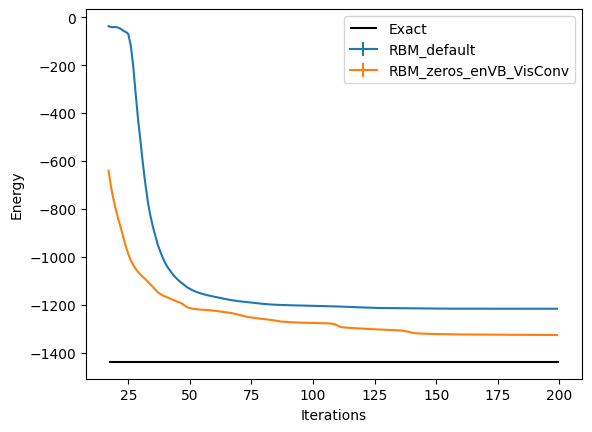

In [ ]:
skip_iter = 17
plt.hlines([E_gs_exact], xmin=skip_iter, xmax=N_iters, color='black', label="Exact")

# for model_name in ('RBM_conv', 'RBM_default'): 'RBM_conv', 'FFN_conv_Nik',
# 'FFN_conv_Igor_sum'
for model_name in ('RBM_default', 'RBM_zeros_enVB_VisConv'): # 'RBM_zeros_enVB_VisConv'):
    if model_name in plot_data:
        cur_name = model_name # 'FFN' #
        plt.errorbar(plot_data[cur_name]["Energy"].iters[skip_iter:], 
                     2*(plot_data[cur_name]["Energy"].Mean[skip_iter:]), 
                    yerr=plot_data[cur_name]["Energy"].Sigma[skip_iter:], label=cur_name)
  
    plt.legend()

    plt.xlabel('Iterations')
    plt.ylabel('Energy')